<a href="https://colab.research.google.com/github/emyesme/ExpectationMaximizationAlgorithm/blob/main/EM%20-%20T1/FLAIR%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries

In [6]:
from matplotlib import pyplot as plt
from skimage import measure
from scipy import stats
import nibabel as nib
import numpy as np
import cv2
import os


from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## functions

In [7]:
# kmeans clustering segmentation 
# vector: matrix: large x 1 -> of intensity values of the brain
# k: number -> quantity of clusters
# return: matrix, matrix 
def segmentation_kmeans(vector, k):
    # color space change
    # matrix = cv2.cvtColor(matrix, cv2.COLOR_BGR2RGB)
    # reshape the image to be a list of pixels
    data = np.float32(vector)

    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Apply KMeans
    compactness,labels,centers = cv2.kmeans(data,k,None,criteria,10,flags)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    res2 = res.reshape((vector.shape))

    mask = cv2.normalize(res2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    #print(mask.shape)
    
    return mask, labels

In [61]:
# given volume, labels and ground truth
# return the vectors of intensity 
# corresponding to csf, wm and gm respectively
# labels: array large x 1 -> volume of labels
# brain: array  240 x 240 x 48 -> volume of intensities of the brain
# gt: array 240 x 240 x 48 -> ground truth
# result: array, array, array
def get_vector_image(labels, brain):
  csf = brain[(labels == 1).reshape(-1)]
  wm = brain[(labels == 2).reshape(-1)]
  gm = brain[(labels == 3).reshape(-1)]

  print('get vector image len(csf) ', len(csf))
  print('get gector image len(wm) ', len(wm))
  print('get vector image len(gm) ', len(gm))

  print("csf zeros ", np.count_nonzero(csf))
  print("wm zeros ", np.count_nonzero(wm))
  print("gm zeros ", np.count_nonzero(gm))

  #m = np.where(gt != 0)

  return csf, wm, gm

In [62]:
# given volume of 2 different sequences return mean and standard deviation
# t1: array  240 x 240 x 48 -> volume of intensities of the brain of one sequence
# flair: array 240 x 240 x 48 -> volume of intensities of the brain of other sequence
# result: array, array -> meand and std for each sequence respectively
def init_mean_cov(t1, flair):

  mean1 = np.mean(t1)
  mean2 = np.mean(flair)
  mean_f = np.vstack((mean1, mean2))

  std_f = np.cov(t1,flair)  

  return mean_f, std_f

In [63]:
# given intensities, weights for a cluster k and nk compute the empirical avg standard
# x: array  2 x large -> volume of intensities of the brain of one sequence
# wk: array large x 1 -> weights in each pixel for cluster k
# nk: number -> sum of all the weights in a cluster k
# result: array 2 x 1 -> meand and std for each sequence respectively
def new_mean(x, wk, nk):  

  result = np.sum(np.multiply(wk, x[:,0,:]), axis=1)

  return result/nk


In [64]:
# given intensities, weights for a cluster k and nk compute the empirical avg standard
# dif: array  2 x large -> difference of intensities with corresponding mean for each pixel
# wk: array large x 1 -> weights in each pixel for cluster k
# nk: number -> sum of all the weights in a cluster k
# result: array 2 x 1 -> meand and std for each sequence respectively
def new_cov(dif, wk, nk):

  result = np.matmul(np.multiply(wk, dif), np.transpose(dif))
  
  return result / nk

In [65]:
# mulvariate gaussian density
# dif: array 2 x large -> xi - mu for each cluster ki
# dim: number -> number of dimensions in this case 2 sequences t1 and flair 
# detstd: array 1 x 3 -> determinant of covariance matrix for each cluster 
# invstd: array 2x2 x 3  -> inverses of matrices of covariance fir each cluster
# result: number
def gauss_mix_model(dif, dim, detstd, invstd):

  tdif = np.transpose(dif)
  pow = (-0.5) * np.matmul(np.matmul( tdif, invstd), (dif)).reshape(-1)[0]
  den = ((2 * np.pi) ** (dim/2)) * (detstd ** (0.5))
  result = ( 1 / den ) * np.exp(pow)

  return result

# compute inverse and determinant of std
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
# result: array, array
def inv_det_std(std):
  # compute inverse of covariance matrices
  invstd = np.array([ [np.linalg.inv(std[0,:,:,:][0])],
                      [np.linalg.inv(std[1,:,:,:][0])],
                      [np.linalg.inv(std[2,:,:,:][0])]])

  # compute determinant of covariance matrices
  detstd = np.array([ np.linalg.det(std[0,:,:,:][0]),
                      np.linalg.det(std[1,:,:,:][0]),
                      np.linalg.det(std[2,:,:,:][0])])
  return invstd, detstd

# multivariate gaussian probability density function
# x: 2 x large -> intensities vector
# k: number -> number of clusters
# mu: array  2x3 -> avg of values for each cluster and dimension
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
def prior_probs_lib(x, k, mu, std ):

  p_gauss = np.zeros((x.shape[2],k))

  for ki in range(k):
    # compute multivariate gaussian
    p_gauss[:,ki] = stats.multivariate_normal.pdf(np.transpose(x[:,0,:]), mean=np.array(mu[:,ki]), cov=std[ki,:,:,:][0])

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu
  
  return p_gauss, dif


# prior probabilities computation
# x: 2 x large -> intensities vector
# k: number -> number of clusters
# mu: array  2x3 -> avg of values for each cluster and dimension
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
# dim: number -> number of dimensions in this case 2 sequeneces t1 and flair
def prior_probs(x, k, mu, std, dim):
  # membership matrix variables
  p_gauss = np.zeros((x.shape[2],k))

  # compute inv and det of std
  invstd, detstd = inv_det_std(std)

  # for each cluster k
  for ki in range(k):

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu

    # compute individual memberships
    for dif_i in range(dif.shape[1]):
      # compute the membership of given intensity value to the cluster ki
      p_gauss[dif_i, ki] = gauss_mix_model(dif[:,dif_i], dim, detstd[ki], invstd[ki,:,:,:][0])

  return p_gauss, dif


# compute the membership by cluster
# p_gauss 2 x large 
# alpha_k: array 1x3 -> proportion of points we have in each cluster
# result: weights matrix: n x k
def membership(p_gauss, alpha):
  
  # compute individual memberships n x k
  numerator = np.multiply(p_gauss, np.array(alpha))
  
  # compute all memberships for denominator of gaussian formula
  denominator = np.matmul(p_gauss, np.array(alpha)) # n x 1

  # for each numerator in i the denominator is the same for the 3 clusters
  rdenominator = np.transpose(np.repeat(np.array([denominator]), k, axis=0))
  
  # weights 
  weights = np.divide(numerator, rdenominator)

  # checking condition of sum row = 1
  #print("checksum ", (np.round(weights.sum(axis=1))==1).all())

  return weights

# prepare probabilities of the voxels
# receive probability maps and brain mask of the deformed atlas
# and return a matrix n x k with n as intensities
# k quantity of clusters -> n x k
def membership_atlas(intensity_atlas, prob_csf, prob_wm, prob_gm):
  # get indexes of brain pixels to start pairing probabilities

  brain_mask = (prob_csf + prob_gm + prob_wm).astype(int) ##########
  print(np.array(brain_mask).shape)

  # indexes of voxels that are part of the brain
  m = np.where(brain_mask != 0)

  # resulting matrix
  result = np.zeros((m.shape[1],m.shape[0]))####

  # pairing
  count=0
  for i, j, k in zip(m[0], m[1], m[2]):
    # place the value of each probabilistic atlas tissue in the corresponding pixel
    result[count, :] = [prob_csf[i, j, k], prob_gm[i, j, k], prob_wm[i, j, k]] # csf, gm, wm
    count += 1

  #print('shape result ', result.shape)
  return result


In [66]:
# Computes soerensen-dice coefficient.

# compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
# and the predicted mask `mask_pred`.

# Args:
#   mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
#   mask_pred: 3-dim Numpy array of type bool. The predicted mask.

# Returns:
#   the dice coeffcient as float. If both masks are empty, the result is NaN.
def compute_dice_coefficient(mask_gt, mask_pred):
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  
  return 2*volume_intersect / volume_sum 

In [226]:
# get the right cluster

def get_right_cluster(gt, labels, image):

  plt.imshow(labels[:,:,24], cmap='gray')
  plt.title("previous right clusters")
  plt.show()

  avgs_gt = []
  avgs_labels = []

  for tissue in [1,2,3]:
    pixels_gt = image[gt == tissue]
    pixels_labels = image[labels == tissue]
    # compute avg of each tissue using gt
    avgs_gt.append(np.mean(pixels_gt))
    # compute avg of each tissue using em result
    avgs_labels.append(np.mean(pixels_labels))

  # save original keys from gt and avgs
  dict_gt = dict(zip(range(1,4), avgs_gt))
  dict_labels = dict(zip(range(1,4), avgs_labels))

  # sort
  avgs_gt.sort()
  avgs_labels.sort()

  # get keys of sorted values in dictionaries
  keys_gt = [key for idx, (key, value) in enumerate(dict_gt.items()) if value ==  avgs_gt[idx]]

  keys_labels = []
  # sort the dictionary
  for k in sorted(dict_labels, key=dict_labels.get, reverse=False):
      keys_labels.append(k)

  # create final lut
  change = np.arange(4)
  for gt, label in zip(keys_gt, keys_labels):
    change[int(label)] = int(gt)
  
  labels = labels.astype(np.uint8)
  
  # change labels
  result = change[labels]

  plt.imshow(result[:,:, 24], cmap='gray')
  plt.title("after right clusters")
  plt.show()


  return result

# Main algorithm

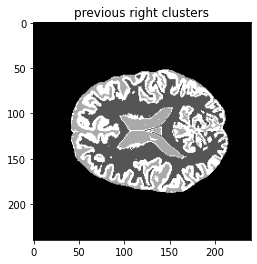

gt shape  (240, 240, 48)
labels shape  (240, 240, 48)
avgs gt  [37.195158052351864, 69.4055587876718, 95.97107285254297]
avgs labels  [94.75531349206233, 34.34690835907022, 67.40209655681694]
2 34.34690835907022
3 67.40209655681694
1 94.75531349206233
[1, 2, 3]
[2, 3, 1]
[0 3 1 2]


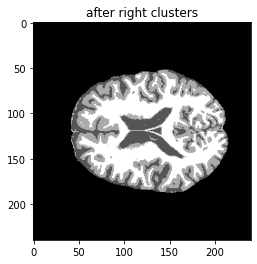

In [224]:
FOLDER_DIR = "/content/drive/MyDrive/MAIA/Semester3/MISA/P2_data/5"

patients = ['1', '2', '3', '4', '5']

# # import data
# for patient in patients:

img = nib.load(os.path.join(FOLDER_DIR, 'T1.nii')).get_fdata()
img_info = nib.load(os.path.join(FOLDER_DIR, 'T1.nii'))
#print(img_info.affine)
img_flair = nib.load(os.path.join(FOLDER_DIR,'T2_FLAIR.nii')).get_fdata()
gt = nib.load(os.path.join(FOLDER_DIR,  'LabelsForTesting.nii')).get_fdata()

# normalisation step
img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
img_flair = cv2.normalize(img_flair, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# skull stripping with the groundtruth mask
brain_t1 = img[gt > 0]
flair = img_flair[gt > 0]

# brain vector of intensities
vector_brain = brain_t1.reshape(-1)

# get kmeans to extract initialisation parameters
kmeans, labels = segmentation_kmeans(vector_brain, 3)

# initialising variable of kmeans labels
reshape_kmeans = np.zeros(img.shape)

# indexes of voxels that are part of the brain
m = np.where(gt != 0)


count = 0
for i, j, k in zip(m[0], m[1], m[2]):
    # reconstruction of labels
    reshape_kmeans[i, j, k] = labels[count] + 1
    count += 1

labels = get_right_cluster(gt, reshape_kmeans, img)

In [229]:
# INITIALIZE 

labels = labels[gt > 0]

# get csf, wm and gm
csf_t1, wm_t1, gm_t1 =  get_vector_image(labels, brain_t1)
csf_fl, wm_fl, gm_fl =  get_vector_image(labels, flair)

# mean and std of csf, wm, gm
mean_csf, std_csf = init_mean_cov(csf_t1, csf_fl) # mean 2x1, std 2x2
mean_wm, std_wm = init_mean_cov(wm_t1, wm_fl) 
mean_gm, std_gm = init_mean_cov(gm_t1, gm_fl)

# initial mu 2x3 and std (2x2)x3
mu = np.hstack((mean_csf, mean_wm, mean_gm))
std = np.array([ [std_csf], [std_wm], [std_gm] ])

# x array of pixels values for both dimensions
x = np.array([ [brain_t1],[flair] ]) # xi is 2x1. 2x1x(all brain pixels)

# initial alpha 
alpha = np.array([1/3,1/3,1/3])

# clusters
k = 3

# iterations
iterations = 500

# dimensions
dim = 2

# initial weights matrix
weights = np.zeros((x.shape[2], k), dtype=np.float32)

# COMPUTE LOGLIKELIHOOD

# compute inv and det of std
invstd, detstd = inv_det_std(std)

# membership matrix variables
# library so fast, 1 second per epoch
p_gauss, dif = prior_probs_lib(x, k, mu, std)
# our 30s per epoch
#p_gauss, dif = prior_probs(x, k, mu, std, dim)

# initial loglikelihood
log_likelihood = -100

get vector image len(csf)  125196
get gector image len(wm)  183617
get vector image len(gm)  161416
csf zeros  125196
wm zeros  183617
gm zeros  161416
get vector image len(csf)  125196
get gector image len(wm)  183617
get vector image len(gm)  161416
csf zeros  125146
wm zeros  183611
gm zeros  161415


In [230]:
# REPEAT while true
import time

start = time.time()

# atlas information extraction
#weights_atlas = membership_atlas(intensity_atlas, prob_csf, prob_wm, prob_gm)

for iteration in range(iterations):

  # EXPECTATION STEP 
  
  # compute membership 
  weights = membership(p_gauss, alpha)
  #weights = np.multiply(weights_belonging, weights_atlas)

  # MAXIMITATION STEP

  # for each cluster
  for ki in range(k):

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu

    # compute  nk
    nk = np.sum(weights[:,ki])
    # compute alpha
    alpha[ki] = nk / x.shape[2]
    # compute mu 
    mu[:,ki] = new_mean(x, weights[:,ki], nk).reshape(-1)
    # compute std
    std[ki,:,:,:][0] = new_cov(dif, weights[:,ki], nk)
    
  # CONVERGENCE RULE

  # compute membership matrix
  
  # library so fast, 1 second per epoch
  p_gauss, dif = prior_probs_lib(x, k, mu, std)
  # our 30s per epoch
  #p_gauss, dif = prior_probs(x, k, mu, std, dim)

  p_gauss_alpha = np.matmul(p_gauss, np.array(alpha))

  # compute likelihood
  tmplikelihood = np.sum(np.log(p_gauss_alpha))
  
  # checking convergence criterion
  #print('dif ', (tmplikelihood - log_likelihood) )

  if np.abs(tmplikelihood - log_likelihood) < 1e-10:
    print("Convergence achieved before ending iterations!")
    break

  log_likelihood = tmplikelihood

  #print('iter ', iteration)

print('Final time: ', time.time()-start)

Convergence achieved before ending iterations!
Final time:  43.989503145217896


In [231]:
# Reconstruct the Brain 

m = np.where(gt != 0)
em = np.zeros(img.shape)
count = 0

for i, j, k in zip(m[0], m[1], m[2]):
    # reconstruction of labels
    em[i, j, k] = np.argmax(weights[count, :]) + 1
    count += 1


# csf_knumber, gm_knumber, wm_knumber
#dice_csf = compute_dice_coefficient(gt == 1, em == 2)
#dice_gm =  compute_dice_coefficient(gt == 2, em == 3)
#dice_wm = compute_dice_coefficient(gt == 3, em == 1)

#print(dice_csf)
#print(dice_gm)
#print(dice_wm)


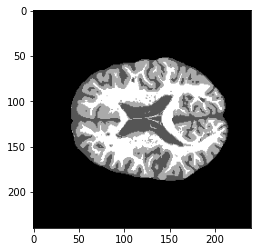

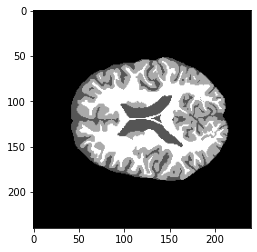

In [232]:
plt.imshow(em[:,:,24], cmap='gray') # em --> csf = 3, gm = 2, wm = 1
plt.show()
plt.imshow(gt[:,:,24], cmap='gray') # gt --> csf = 1, gm = 2, wm = 3
plt.show()

In [ ]:
data = np.ones(img.shape, dtype=np.int16)
img_new = nib.Nifti1Image(em, img_info.affine)
img_new.get_data_dtype() == np.dtype(np.int16)

nib.save(img_new, '/content/drive/MyDrive/MAIA/Semester3/MISA/P2_data/5/volume_patient5.nii')